<a href="https://colab.research.google.com/github/mehrshadshams/Museums/blob/master/Museums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import io
import re
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

Installing Basic Requirements

In [0]:
!pip install wikipedia beautifulsoup4 pycountry requests_cache

In [0]:
import wikipedia
import pycountry
import requests_cache

from collections import namedtuple
from bs4 import BeautifulSoup


In [0]:
requests_cache.install_cache('req_cache')

In [0]:
Museum = namedtuple('Museum', ['name', 'country', 'city', 'visitors', 'population', 'year'])

In [0]:
countries = pycountry.countries

Loading World population data from UN data export

In [0]:
un_city_pop = pd.read_csv("https://raw.githubusercontent.com/mehrshadshams/Museums/master/data.csv")
un_city_pop = un_city_pop[un_city_pop['Sex'] == 'Both Sexes']
un_city_pop.City = un_city_pop.City.str.lower()

In [0]:
regex = r"(\d{4}).*"

# To Deal with name differences between Wikipedia and UN data export
def normalize_country_name(name):
  if '(' in name:
    idx = name.index('(')
    if idx >= 0: 
      name = name[:idx].strip()
  return name


def normalize_city_name(name):
  if "," in name:
    idx = name.index(',')
    if idx >= 0:
      name = name[:idx].strip()
  return name


def find_country_by_name(name):
  name = name.lower()
  if name.startswith('vatican'):
    name = 'Holy See (Vatican City State)'.lower()
  elif name.startswith('south korea'):
    name = 'Korea, Republic of'.lower()
  
  def filter_func(x):
    return (hasattr(x, 'common_name') and x.common_name.lower() == name) or \
          x.name.lower().startswith(name)
  
  temp = list(filter(lambda x: x.name.lower() == name, countries))
  if len(temp) == 0:
    temp = list(filter(filter_func, countries))
    if len(temp) == 0:
      raise ValueError("invalid country " + name)
  return temp[0]


def get_city_population(city, country):
  country_name = normalize_country_name(country.name)
  city_name = normalize_city_name(city.lower())

  
  print("Find population for Country='{0}', City='{1}'".format(country.name, city))
  url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q={0}&sort=population&facet=country&refine.country={1}"
  req = requests.get(url.format(city_name, country.alpha_2.lower()))
  req.raise_for_status()
   
  data = req.json()

  if len(data) > 0:
    records = data['records']
    if len(records) > 0:
      fields = records[0]['fields']
      if 'population' in fields:  
        return fields['population']
      
  if city_name.endswith('city'):
    city_name = city_name[:city_name.index('city')].strip()
    return get_city_population(city_name, country)
  else:
    df = un_city_pop[un_city_pop['Country or Area'].str.contains(country_name, na=False)]
    df = df[df['City'].str.contains(city_name, na=False)].sort_values(['Year'], ascending=False)
    if len(df) > 0:
      return int(df[0:1]['Value'].values[0])
  
  return -1


def extract_list_of_musueum_data():
  m = wikipedia.page('List_of_most_visited_museums')
  soup = BeautifulSoup(m.html(), 'html.parser')
  table = soup.find_all('table')[0]
  rows = table.find_all('tr')[2:]
  data = []
  for row in rows:
    cells = row.find_all('td')
    name = cells[0].find('a').attrs['title']
    
    cell_links = cells[1].find_all('a')
    country_name = cell_links[0].attrs['title']
    
    country = find_country_by_name(country_name)   
    city = cell_links[1].attrs['title']
    visits = int(cells[2].text.replace(',',''))
        
    matches = list(re.finditer(regex, str(cells[3].text), re.MULTILINE))
    year = int(matches[0].groups()[0])
    
    population = get_city_population(city, country)
    
    data.append(Museum(name, country, city, visits, population, year))
    
  return data

In [0]:
data = extract_list_of_musueum_data()

Find population for Country='France', City='Paris'
Find population for Country='China', City='Beijing'
Find population for Country='United States', City='Washington, D.C.'
Find population for Country='United States', City='New York City'
Find population for Country='United States', City='new york'
Find population for Country='Holy See (Vatican City State)', City='Vatican City'
Find population for Country='Holy See (Vatican City State)', City='vatican'
Find population for Country='China', City='Shanghai'
Find population for Country='United States', City='Washington, D.C.'
Find population for Country='United Kingdom', City='London'
Find population for Country='United Kingdom', City='London'
Find population for Country='United States', City='Washington, D.C.'
Find population for Country='United Kingdom', City='London'
Find population for Country='United States', City='New York City'
Find population for Country='United States', City='new york'
Find population for Country='Taiwan, Province 

In [0]:
list(filter(lambda m: m.population == -1, data))

[]

In [0]:
sns.set(color_codes=True)


In [0]:
df = pd.DataFrame(data)
df['country'] = df['country'].apply(lambda x: x.alpha_2)

In [0]:
df.head()

,name,country,city,visitors,population,year
0,Louvre,FR,Paris,8100000,2110694,2017
1,National Museum of China,CN,Beijing,8062625,19612368,2017
2,National Air and Space Museum,US,"Washington, D.C.",7000000,552433,2017
3,Metropolitan Museum of Art,US,New York City,6692909,8107916,2017
4,Vatican Museums,VA,Vatican City,6427277,451,2017


In [0]:
nm_per_country = df.groupby(['country'])['name'].count().reset_index(name="museum_count")

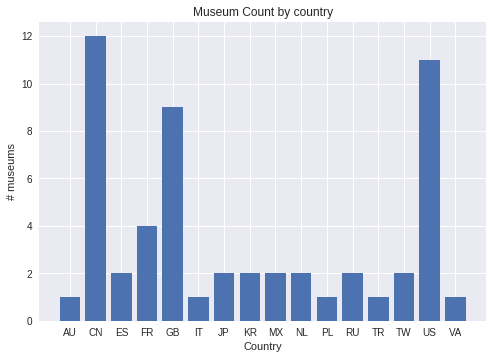

In [0]:
_ = plt.bar(nm_per_country.country.values, nm_per_country.museum_count.values)
_ = plt.title('Museum Count by country')
_ = plt.xlabel('Country')
_ = plt.ylabel('# museums')

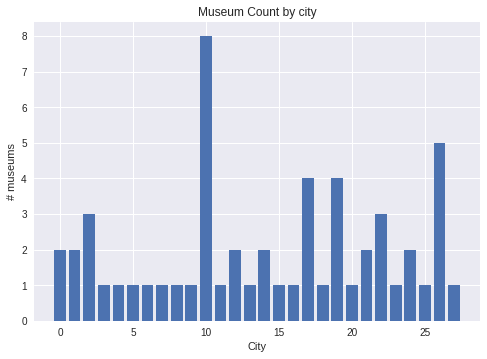

In [0]:
temp = df.groupby(['city'])['name'].count().reset_index(name='museum_count');

_ = plt.bar(range(len(temp)), temp.museum_count.values)
_ = plt.title('Museum Count by city')
_ = plt.xlabel('City')
_ = plt.ylabel('# museums')

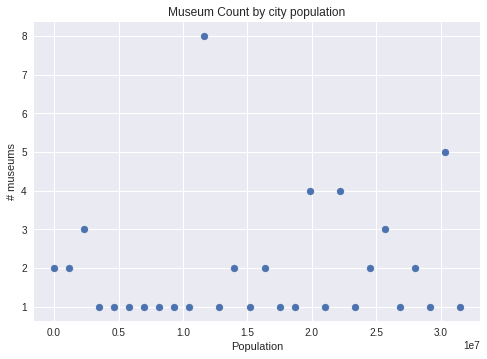

In [0]:
x = np.linspace(df.population.min(), df.population.max(), len(temp))
p = plt.scatter(x, temp['museum_count'])
_ = plt.title('Museum Count by city population')
_ = plt.xlabel('Population')
_ = plt.ylabel('# museums')

In [0]:
temp = df.groupby(['city']).sum()
temp.head()

,visitors,population,year
city,,,
Amsterdam,4260000,1491622,4034
Beijing,12045625,39224736,4034
Chongqing,7502000,11901084,6051
Edinburgh,2165601,435794,2017
Florence,2200000,347194,2017


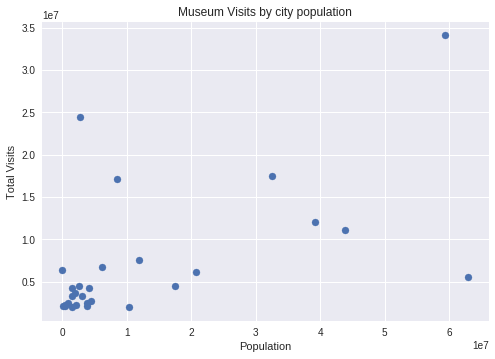

In [0]:
p = plt.scatter(temp.population, temp['visitors'])
_ = plt.title('Museum Visits by city population')
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Visits')

In [0]:
from sklearn import linear_model

In [0]:
X = temp.population.values.reshape(-1, 1)
y = temp.visitors.values.reshape(-1, 1)

clf = linear_model.LinearRegression()
clf.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

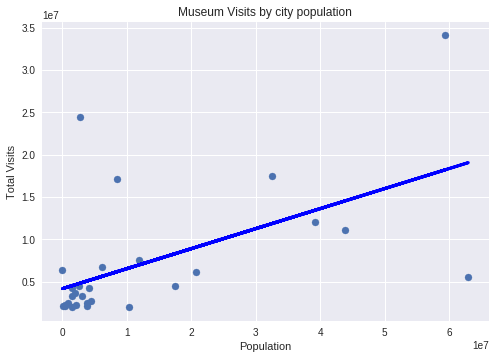

In [0]:
p = plt.scatter(temp.population, temp['visitors'])
_ = plt.title('Museum Visits by city population')
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Visits')

y_hat = clf.predict(X)
_ = plt.plot(X, y_hat, color='blue', linewidth=3)
